In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.options.display.max_columns = 30

# Load data

In [2]:
data = pd.read_excel('data_sul_days_15y.xlsx')
data = data[['Data Escala de Tempo 1 CE Simp 4', 'Selecione Tipo de CE Simp 4']]
data.columns = ['date','load']
data = data[2:]
data.shape

(5995, 2)

In [3]:
data.iloc[np.r_[0:2, -2:0]]

,date,load
2,2005-01-01 00:00:00,134.95552
3,2005-02-01 00:00:00,140.24240
5995,05/30/2021 12:00:00 a.m.,209.56636
5996,05/31/2021 12:00:00 a.m.,276.47700


In [4]:
init_date = datetime(2005, 1, 1)
datelist = pd.date_range(init_date, periods=len(data)).tolist()

In [5]:
df = pd.DataFrame(data=data.load.values, index=datelist, columns=['Energy_Load'])
df.iloc[np.r_[0:2, -2:0]]

,Energy_Load
2005-01-01,134.95552
2005-01-02,140.24240
2021-05-30,209.56636
2021-05-31,276.47700


In [6]:
df[df.Energy_Load.isnull()]

,Energy_Load
2014-02-01,NaN


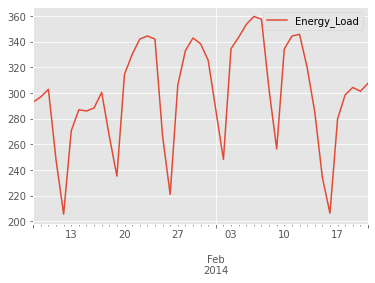

In [7]:
df.loc['2014-02-01','Energy_Load'] = (325.547854 + 248.323577)/2.
df.loc['2014-01-08':'2014-02-21'].plot()

In [8]:
df1 = df.resample('1M').sum()[['Energy_Load']]
df1['date'] = df1.index
df1['year'] = df1.date.dt.year
df1['month'] = df1.date.dt.month
df1.shape

(197, 4)

### Train-test split

In [9]:
train = df1.loc['2005-01-01':'2017-12-31']
val = df1.loc['2017-01-01':'2018-12-31']
test = df1.loc['2018-01-01':'2019-12-31']

## Data Pre-Processing

In [11]:
max_ = 8854.093328099998
min_ = 5183.659522000001

def preprocess(df_, scale=False, windows=None):

    _xt = []
    for i in range(windows, len(df_)):
        _y = df_.iloc[i]
        _xt_w = list(df_.iloc[i-windows:i].Energy_Load.values)
        _x = _xt_w + [_y.Energy_Load]
        _xt.append(_x)
        
    _X = pd.DataFrame(_xt, columns=cols)
    
    if scale:
        _X = (_X- min_)/(max_ - min_)
    
    return _X

# Model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

In [13]:
def create_model(hidden_neurons=[4], lr=0.001, n_input=1, windows=None):
    tf.random.set_seed(42)
    in_=Input(shape=(windows,1)) 
    x=LSTM(hidden_neurons[0])(in_)
    out_=Dense(1,)(x)
    model=Model(in_, out_)

    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [14]:
def calculate_metrics(y_true, y_predict, rescaling=True):
    
    if rescaling:
        y_true = y_true*(max_- min_) + min_
        y_predict = y_predict*(max_ - min_) + min_

    mae_error = mean_absolute_error(y_true, y_predict)
    mse_error = mean_squared_error(y_true, y_predict)
    rmse_error = np.sqrt(mse_error)
    mape = np.mean(np.abs((y_true.ravel() - y_predict.ravel()) / y_true.ravel())) * 100


    print(f'Erro MAE = {round(mae_error,3)}\nErro RMSE = {round(rmse_error,3)}')
    print("MAPE: ", np.round(mape,3), "%")

In [15]:
def multistep(x_, y_, model_, mode="binary"):

    yp = []
    
    if mode=="binary":
        L=0
    elif mode=="Nof1":
        L=12

    input_ = np.copy(x_)
    input_ = np.expand_dims(input_[0], axis=0) # just the first row // for val -> 12 steps // for test -> 5 steps

    for i in range(len(x_)):
        yt_ = model_.predict(input_)[0][0]
        yp.append(yt_)
        
        if i < len(x_)-1:
            # update input
            input_[0,L:-1] = input_[0,(L+1):]
            input_[0,-1] = yt_

    return np.array(yp)

# Optimization

In [16]:
!pip install deap
!pip install bitstring

In [17]:
from deap import base, creator, tools, algorithms
import random

In [18]:
def aptidao(y_true, y_predict):
    
    y_true = y_true*(max_- min_) + min_
    y_predict = y_predict*(max_ - min_) + min_
    mape = np.mean(np.abs((y_true.ravel() - y_predict.ravel()) / y_true.ravel())) * 100
    print("MAPE: ", mape)

    return mape

In [19]:
def train_evaluate(ga_individual_solution): 

    global cols

    num_units, epochs, wdw = ga_individual_solution
    print('\nNum of Units: {} - epochs: {} - windows: {}'.format(num_units, epochs, wdw))

    # data pre-processing
    lt_w = ['x[t-{}]'.format(str(i)) for i in reversed(range(wdw))]
    cols = lt_w + ['x[t]']
    X = preprocess(train, windows=wdw, scale=True)
    Xval = preprocess(val, windows=wdw, scale=True)

    x_train = X.values[:,:-1]
    y_train = X.values[:,-1]

    x_val = Xval.values[:,:-1]
    y_val = Xval.values[:,-1]

    # Train neural network and predict on validation set
    model = create_model(hidden_neurons = [num_units], n_input = x_train.shape[1], lr = 0.001, windows=wdw)
    model.fit(x_train, y_train, epochs=epochs, verbose=0)

    y_pred_val_ms = multistep(x_val, y_val, model)
    
    # Calculate the MAPE score as fitness score for GA
    return aptidao(y_val, y_pred_val_ms),

In [20]:
population_size = 30
num_generations = 10

creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list,  fitness=creator.FitnessMax) 

toolbox = base.Toolbox()

toolbox.register("attr_int1", random.randint, 5, 150) # units
toolbox.register("attr_int2", random.randint, 5, 200) # epochs
toolbox.register("attr_int3", random.randint, 1, 12)  # windows

# Individuals and population
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int1, toolbox.attr_int2, toolbox.attr_int3), 1) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operations
toolbox.register("evaluate", train_evaluate)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, low=[5,5,1], up=[150,200,12], indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


population = toolbox.population(n=population_size)
r = algorithms.eaSimple(population, toolbox, cxpb=0.4, mutpb = 0.1, ngen=num_generations, verbose = False)


Num of Units: 54 - epochs: 145 - windows: 11
MAPE:  4.07338979069035

Num of Units: 70 - epochs: 29 - windows: 5
MAPE:  4.4756972397706045

Num of Units: 148 - epochs: 177 - windows: 1
MAPE:  5.687461636063755

Num of Units: 9 - epochs: 47 - windows: 4
MAPE:  8.209511605307174

Num of Units: 55 - epochs: 83 - windows: 9
MAPE:  5.578491618382881

Num of Units: 103 - epochs: 55 - windows: 6
MAPE:  7.158878434356346

Num of Units: 139 - epochs: 68 - windows: 5
MAPE:  6.911022947531316

Num of Units: 48 - epochs: 185 - windows: 2
MAPE:  5.3650254556337345

Num of Units: 69 - epochs: 188 - windows: 11
MAPE:  4.75308168322524

Num of Units: 18 - epochs: 150 - windows: 12
MAPE:  3.3269736940388603

Num of Units: 150 - epochs: 25 - windows: 12
MAPE:  5.620013946446607

Num of Units: 122 - epochs: 49 - windows: 1
MAPE:  6.1223637147528756

Num of Units: 28 - epochs: 105 - windows: 9
MAPE:  6.185241642000973

Num of Units: 99 - epochs: 101 - windows: 9
MAPE:  6.311614222197832

Num of Units: 6 

In [21]:
# Print top N solutions
best_individuals = tools.selBest(population, k=3)

for bi in best_individuals:
    print(bi)
    # train_evaluate(bi)

[83, 180, 12]
[83, 180, 12]
[83, 180, 12]


# Train with optimized parameters

In [22]:
hn, ep, windows = best_individuals[0]

# hn = 75
# ep = 131
# windows = 6

In [23]:
lt_w = ['x[t-{}]'.format(str(i)) for i in reversed(range(windows))]
cols = lt_w + ['x[t]']
X = preprocess(train, windows=windows, scale=True)
Xval = preprocess(val, windows=windows, scale=True)

x_train = X.values[:,:-1]
y_train = X.values[:,-1]

x_val = Xval.values[:,:-1]
y_val = Xval.values[:,-1]

In [24]:
model1 = create_model(hidden_neurons = [hn], n_input = x_train.shape[1], windows=windows)

In [25]:
hs1 = model1.fit(x=x_train, y=y_train, epochs=ep,
                 validation_data=(x_val, y_val), verbose=0)

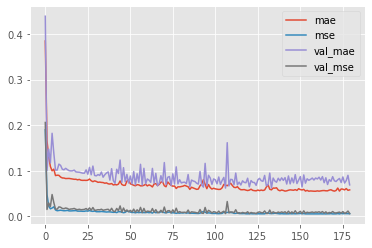

In [26]:
plt.plot(hs1.history['loss'], label="mae")
plt.plot(hs1.history['mean_squared_error'], label="mse")
plt.plot(hs1.history['val_loss'], label="val_mae")
plt.plot(hs1.history['val_mean_squared_error'], label="val_mse")
plt.legend()
plt.show()

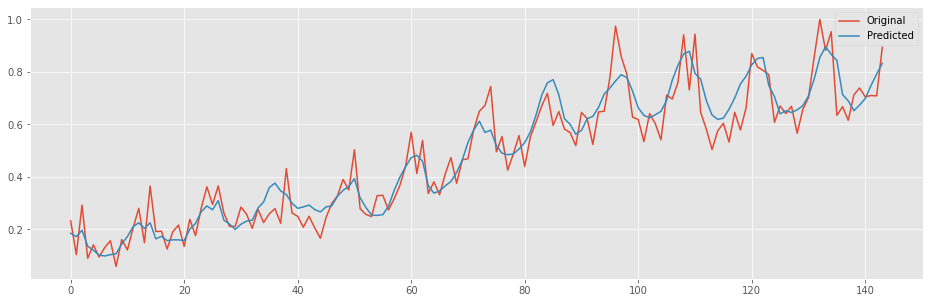

In [27]:
y_train_hat = model1.predict(x_train)

plt.figure(figsize=[16,5])
plt.plot(y_train)
plt.plot(y_train_hat)
plt.legend(['Original','Predicted'])

In [28]:
y_val_hat = model1.predict(x_val)
y_val_ms = multistep(x_val, y_val, model1)
calculate_metrics(y_val, y_val_ms)

Erro MAE = 226.93
Erro RMSE = 266.951
MAPE:  2.766 %


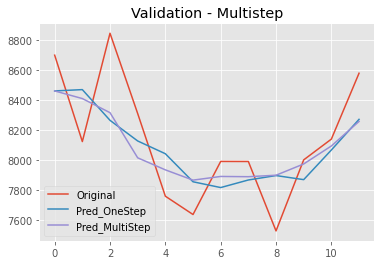

In [29]:
plt.plot(y_val*(max_- min_) + min_)
plt.plot(y_val_hat.ravel()*(max_- min_) + min_)
plt.plot(y_val_ms*(max_- min_) + min_)
plt.legend(['Original','Pred_OneStep', 'Pred_MultiStep'])
plt.title('Validation - Multistep')
plt.show()

# Testing

In [31]:
Xtest = preprocess(test, windows=windows, scale=True)
x_test = Xtest.values[:,:-1]
y_test = Xtest.values[:,-1]

In [32]:
y_test_hat = model1.predict(x_test)
y_test_ms = multistep(x_test, y_test, model1)

In [33]:
calculate_metrics(y_test, y_test_ms)

Erro MAE = 266.97
Erro RMSE = 391.19
MAPE:  3.105 %


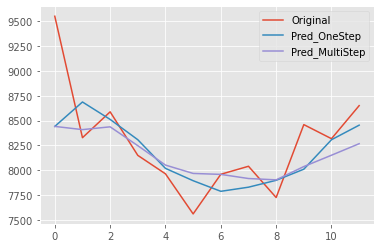

In [34]:
plt.plot(y_test*(max_- min_) + min_)
plt.plot(y_test_hat.ravel()*(max_- min_) + min_)
plt.plot(y_test_ms*(max_- min_) + min_)
plt.legend(['Original','Pred_OneStep', 'Pred_MultiStep'])
plt.show()